# Telco Customer Churn

Churn prediction is the process of identifying which consumers are most likely to stop using a service or to cancel their subscription. It is important to be able to predict customers churn because it is actually expensive to get new customers than keeping existing ones. Once we pinpointed the clients who are most likely to churn, we could find marketing strategy to increase the likelihood that the client will stay.

So in this notebook, we will try to predict customers churn and analyze the factors that cause customer churn in the company. We will use various methods such as logistic regression, random forest, and also XGBoost to make the classification modeling.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn import over_sampling

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import Data

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')

## Data Understanding

In [3]:
df.shape

(7043, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


The raw data contains 7043 rows (customers) and 21 columns (features), which are:
1. **customerID**: Customer ID
2. **gender**: Whether the customer is a male or a female
3. **SeniorCitizen**: Whether the customer is a senior citizen or not (1, 0)
4. **Partner**: Whether the customer has a partner or not (Yes, No)
5. **Dependents**: Whether the customer has dependents or not (Yes, No)
6. **tenure**: Number of months the customer has stayed with the company
7. **PhoneService**: Whether the customer has a phone service or not (Yes, No)
8. **MultipleLines**: Whether the customer has multiple lines or not (Yes, No, No phone service)
9. **InternetService**: Customer’s internet service provider (DSL, Fiber optic, No)
10. **OnlineSecurity**: Whether the customer has online security or not (Yes, No, No internet service)
11. **OnlineBackup**: Whether the customer has online backup or not (Yes, No, No internet service)
12. **DeviceProtection**: Whether the customer has device protection or not (Yes, No, No internet service)
13. **TechSupport**: Whether the customer has tech support or not (Yes, No, No internet service)
14. **StreamingTV**: Whether the customer has streaming TV service or not (Yes, No, No internet service)
15. **StreamingMovies**: Whether the customer has streaming Movies service or not (Yes, No, No internet service)
16. **Contract**: Type of contract (Month-to-month, One year, Two year)
17. **PaperlessBilling**: Whether the customer use paperless billing or not (Yes, No)
18. **PaymentMethod**: Type of payment method (Electronic check, Mailed check, Bank transfer (automatic), and Credit card (automatic))
19. **MonthlyCharges**: How much is their monthly charges
20. **TotalCharges**: How much is their total charges
21. **Churn**: Our target feature, whether the customers churn or not (Yes, No)

If we look at the data type of our column, we know that `TotalCharges` should be in numerical values. However, it is now as object so we have to change it. We also observed that customerID is actually a unique value, let's just drop it.

In [6]:
#change TotalCharges to float
df = df.loc[~df['TotalCharges'].str.contains(' ')]
df['TotalCharges'] = df['TotalCharges'].astype(float)

#drop customerID
df = df.drop(['customerID'], axis = 1)

## Statistical summary

In [7]:
categoricals = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                'PaperlessBilling', 'PaymentMethod', 'Churn']
numericals = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [8]:
df[numericals].describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


Observation:
* Overall, the minimum and maximum values make sense for each column
* `SeniorCitizen` column is boolean column since the value is either 0 or 1, no need to conclude its simmetricity.
* Mean and Median difference in `tenure` and `MonthlyCharges` have severe skewed distribution. Meanwhile `TotalCharges` column indicating asymmetrical distribution (has skewed distribution).

In [9]:
df[categoricals].describe().T

,count,unique,top,freq
gender,7032,2,Male,3549
Partner,7032,2,No,3639
Dependents,7032,2,No,4933
PhoneService,7032,2,Yes,6352
MultipleLines,7032,3,No,3385
InternetService,7032,3,Fiber optic,3096
OnlineSecurity,7032,3,No,3497
OnlineBackup,7032,3,No,3087
DeviceProtection,7032,3,No,3094
TechSupport,7032,3,No,3472


Observations:
* `customerID` has distinct value. We may neglect this column for further analysis.
* `gender` has 2 unique value, 'Male' and 'Female', with the distribution almost balance.
* `Partner`, `Dependents`, `PhoneService`, `PaperlessBilling` and `Churn` have 2 unique value, 'yes', and 'no'.
* There are more customer who has no partner and no dependents.
* Most people use Phone Service  but with no Multiple line.
* Most people use Internet service. Mostly use Fiber optic and the other use DSL. Only 1526 rows that did not use internet service at all.
* Among people who used internet service, they did not use additional service such as: Online Security, Online Backup, Device Protection, Tech Support, Streaming TV and Streaming Movies, because those columns have 'No' as majority value.
* There are 3 types of contract accepted in Telco (Month-to-month, Two year, and One year). The majority of contract type is Month-to-month.
* There are 4 types of payment method (Electronic check, Mailed check, Bank transfer (automatic), and Credit card (automatic). The majority of payment method is electronic.
* The majority of customer chose paperless billing
* There is 5174 people that did not churn and 1869 did churn. 26% of total customer did churn.

## Univariate Analysis

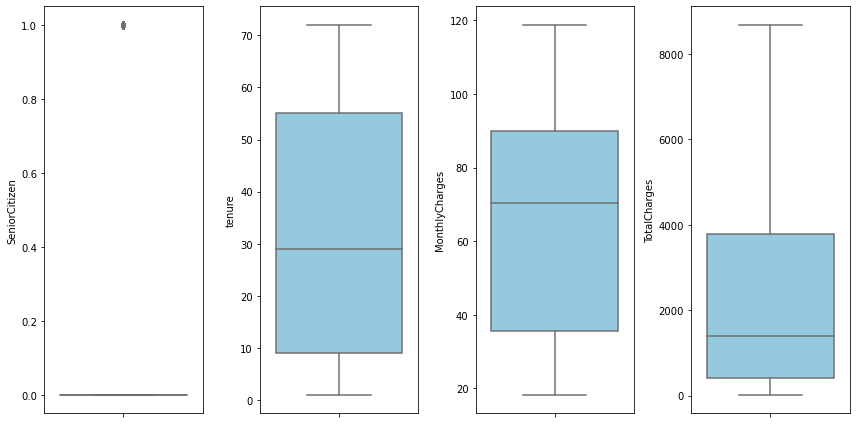

In [10]:
plt.figure(figsize=(12,6))
features = numericals
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=df[features[i]], color='skyblue')
    plt.tight_layout()

Observation:
* We can confirm that `SeniorCitizen` is boolean column since the value is either 0 or 1.
* We can also confirm from the boxplot that `tenure` and `TotalCharges` has positive skew and `MonthlyCharges` has negative skew.
* There is no outliers found in all numerical columns.

### KDE plot for knowing the distribution form

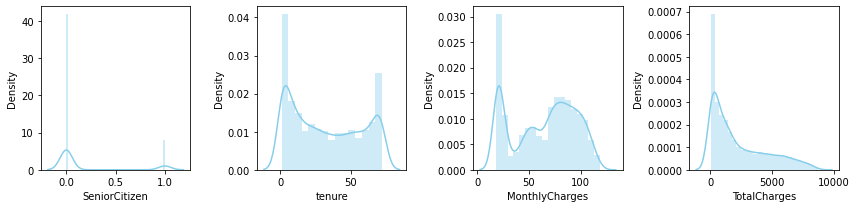

In [11]:
# adjust the figure size for better readability
plt.figure(figsize=(12,3))

features = numericals
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.distplot(x=df[features[i]], color='skyblue')
    plt.xlabel(features[i])
    plt.tight_layout()

Observation:
* We can ignore interpreting the symmetricity of `SeniorCitizen` column due to the limited discrete values. However, from this plot we can understand that majority of the customers are not a Senior Citizen. There is imbalance between Senior Citizen and non Senior Citizen.
* The true continuous numeric features: `tenure`, `MonthlyCharges`, and `TotalCharges` are not symmetric, so we need to transform them to approximate normal distribution.
* Most customers have stayed with the company for 1 month, the second has stayed for 72 months.
* Most customers have monthly charges of 18.25. Since most customers stayed for only 1 month, the majority value of total charges are around 18.8 (not so different from their monthly charges).

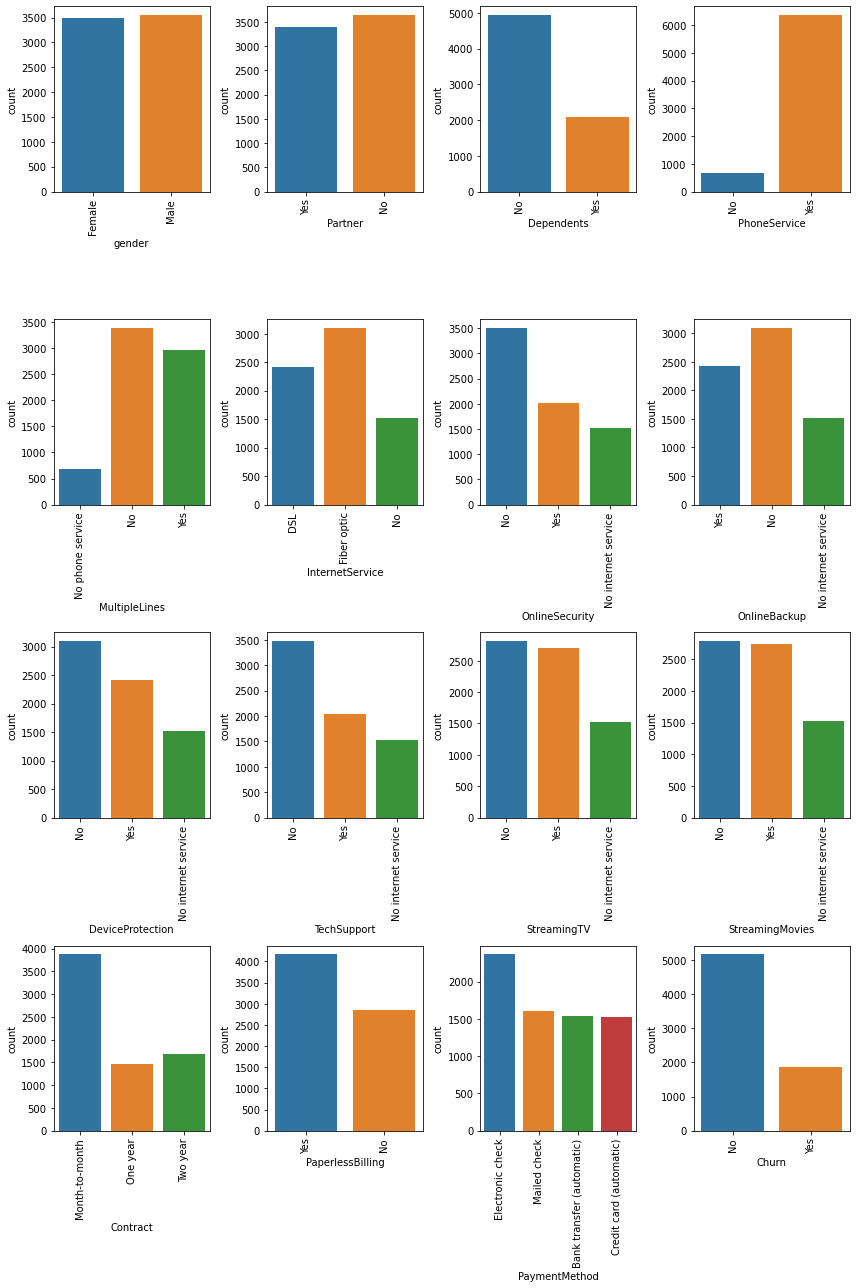

In [12]:
plt.figure(figsize=(12, 18))
features = categoricals
for i in range(0, len(features)):
    plt.subplot(4, 4, i+1)
    sns.countplot(data=df, x=features[i])
    plt.xlabel(features[i])
    plt.xticks(rotation=90)
    plt.tight_layout()

Observations:
* Columns that have good balance are `gender` and `Partner`.
* There are more customer who has no dependents.
* Most people use Phone Service  but with no Multiple line although the difference is not extreme.
* Most people use Internet service. Mostly use Fiber optic and the other use DSL.
* Among people who used internet service, they did not use additional service such as: Online Security, Online Backup, Device Protection, Tech Support, Streaming TV and Streaming Movies, because those columns have 'No' as majority value.
* The majority of contract type is Month-to-month and the majority of payment method is electronic.
* The majority of customer chose paperless billing
* There is more people who did not churn than who did churn.

## Bivariate Analysis

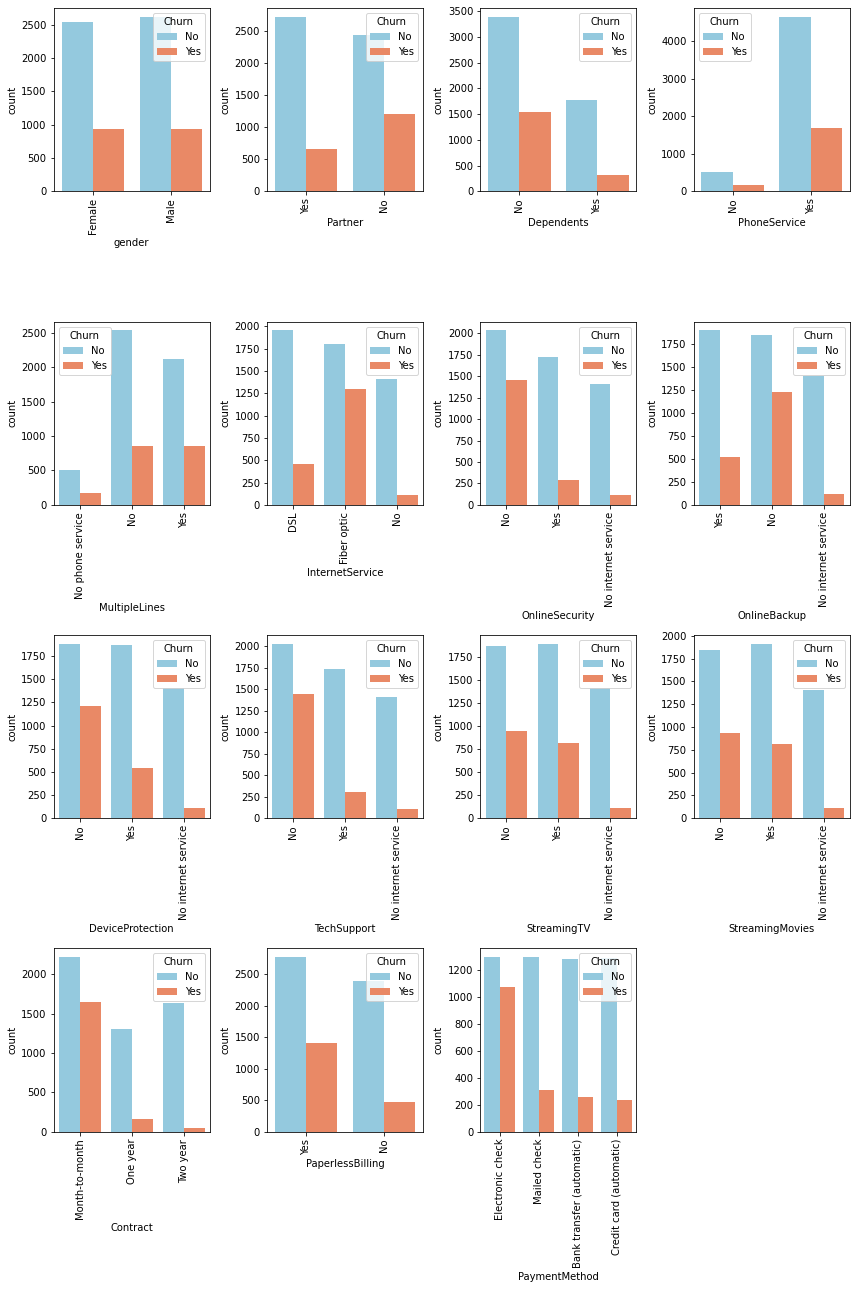

In [13]:
plt.figure(figsize=(12, 18))
features = categoricals
for i in range(0, len(features)-1):
    plt.subplot(4, 4, i+1)
    sns.countplot(data=df, hue='Churn', x=features[i], palette = ['skyblue', 'coral'])
    plt.xlabel(features[i])
    plt.xticks(rotation=90)
    plt.tight_layout()

Observations:
* Gender is not affecting the churn.
* Customers who are more likely to churn:
    - who doesn't have partner
    - who doesn't have dependants
    - who has phone service
    - who use fiber optic as internet service
    - who didn't subscibe to any extra services 
      (Online Backup, Online Security, etc)
    - who has contract month-to-month basis
    - who chose Paperless Billing
    - who use Electronic check

<AxesSubplot:>

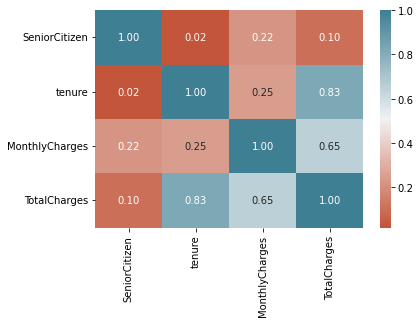

In [14]:
correlation = df.corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap=sns.diverging_palette(20, 220, n=200))

Observation:
* `tenure` is highly correlated to `TotalCharges` but not to `MonthlyCharges`. However `MonthlyCharges` and `TotalCharges` are somehow correlated to each other but the correlation value is less than 0.8. 

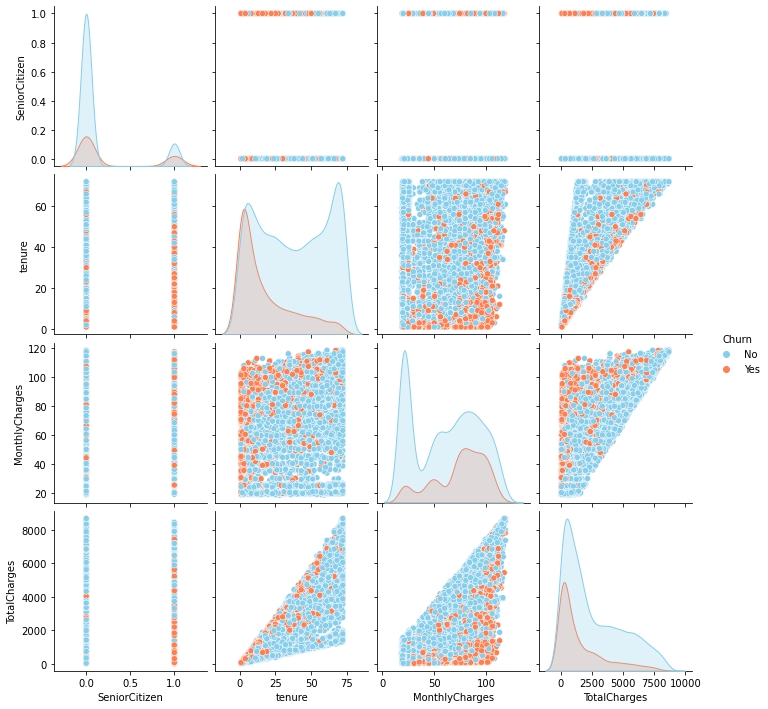

In [15]:
# pairplot of the data
sns.pairplot(df, hue='Churn', palette=['skyblue', 'coral'])

Observations:
* Non senior citizen is most likely to churn
* Customer that has shorter time subscribe the service (smaller tenure) most likely to churn
* Customer with lower MonthlyCharges is most likely to stay, and the higher Monthly Charges is most likely to churn.
* Interestingly, customers with lower TotalCharges is most likely to churn

## EDA Conclusion
1. The data does not contain major issues. There is no NULL values and duplicated rows.
2. Overall, the minimum and maximum values make sense for each column.
3. Most of the columns with continuous numerical values are asymmetric.
4. From the boxplot we can not found any outlier in any numerical columns. 5. In terms of the target variable, there is an imbalance distribution. `churn = No` is more frequent in the dataset.
6. Most customers se Phone service and Internet service. However most of them didn't subscribe to extra service. Only Online Security and Online Backup shows good amount of subscribers.
6. From barcharts, we can say that gender is not affecting the churn. But there are several tendency of customers who are more likely to churn:
    - they don't have partner
    - they don't have dependants
    - they has phone service and use fiber optic as internet service
    - they didn't subscibe to any extra services
    - they has contract month-to-month basis
    - they chose Paperless Billing
    - they used Electronic check
7. From correlation heatmap, we can see that `tenure` is highly correlated to `TotalCharges`. `MonthlyCharges` and `TotalCharges` are somehow look correlated to each other but actualy the correlation value is less than 0.8.
8. From pair plot, we can see that:
    - non senior citizen is most likely to churn
    - Customer that has shorter time subscribe the service (smaller tenure) most likely to churn
    - Customers with lower `MonthlyCharges` is most likely to stay, and the higher `MonthlyCharges`, more likely they churn.
    - Customers with lower `TotalCharges` is most likely to churn

## Deep-dive Exploration 

After exploring the statistical summary of data, let's explore deep dive questions.

1. How is the the distribution of monthly charges compared to the gender and seniority?
2. How is the distribution of service that used by the customers? Is there any service that popular than others?
3. How is the charge distribution based on the service they use?
4. In respect to people who use internet service, what is the best extra services that sell?
5. What is the most popular Payment Bill dihubungkan dengan tipe kontrak?

#### 1. Distribution of Charges in respect to gender and seniority

In [16]:
charges = df.groupby(['gender', 'SeniorCitizen']).agg(
    monthly_charges = ('MonthlyCharges', 'median'),
    total_charges = ('TotalCharges', 'median')).reset_index()
charges

,gender,SeniorCitizen,monthly_charges,total_charges
0,Female,0,66.250,1270.20
1,Female,1,85.225,2263.75
2,Male,0,65.600,1309.15
3,Male,1,84.250,2251.45


Senior Citizens are most likely to have higher monthly charges and total charges. They pay more for the service. We can also confirm that with boxplot below.

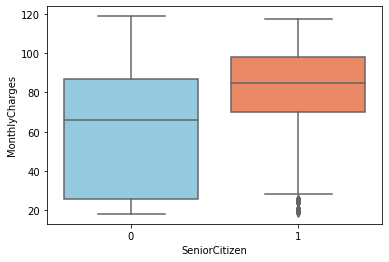

In [17]:
sns.boxplot(data=df,
            x='SeniorCitizen',
            y='MonthlyCharges',
           palette = ['skyblue', 'coral'])
plt.show()

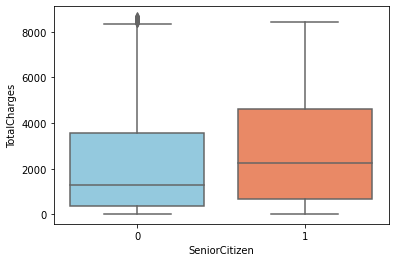

In [18]:
sns.boxplot(data=df,
            x='SeniorCitizen',
            y='TotalCharges',
           palette = ['skyblue', 'coral'])
plt.show()

#### 2. Popular service

In [19]:
top_service = (df.groupby(['PhoneService','InternetService'])
            .agg(num_user=('InternetService','count'))
            .sort_values('num_user',ascending=False).reset_index())
top_service

,PhoneService,InternetService,num_user
0,Yes,Fiber optic,3096
1,Yes,DSL,1736
2,Yes,No,1520
3,No,DSL,680


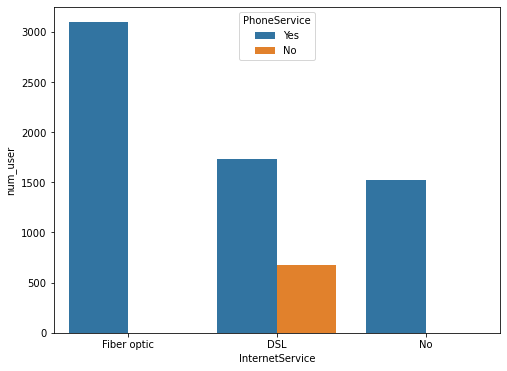

In [20]:
plt.figure(figsize=(8,6))
sns.barplot(data=top_service, x='InternetService', y='num_user', hue='PhoneService')
plt.show()

Most people use phone service and Fiber optic as their internet service. However, for people who didn't use PhoneService, all of them use DSL as their InternetService

#### 3. Charge distribution based on the service

In [21]:
charges = (df.groupby(['PhoneService','InternetService']).agg(
    monthly_charges = ('MonthlyCharges', 'mean')).sort_values('monthly_charges',ascending=False).reset_index())

charges

,PhoneService,InternetService,monthly_charges
0,Yes,Fiber optic,91.500129
1,Yes,DSL,64.392713
2,No,DSL,41.992500
3,Yes,No,21.076283


The higher charge is for the one who ise phone service and Fiber optic as their internet service.

#### 4. Extra service that sell

In [22]:
service_list = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
service_df = pd.melt(df[df["InternetService"] != "No"][service_list]).rename({'variable':'Service', 'value': 'Subscribe'}, axis=1)
service_df

,Service,Subscribe
0,OnlineSecurity,No
1,OnlineSecurity,Yes
2,OnlineSecurity,Yes
3,OnlineSecurity,Yes
4,OnlineSecurity,No
...,...,...
33067,StreamingMovies,Yes
33068,StreamingMovies,Yes
33069,StreamingMovies,No
33070,StreamingMovies,No


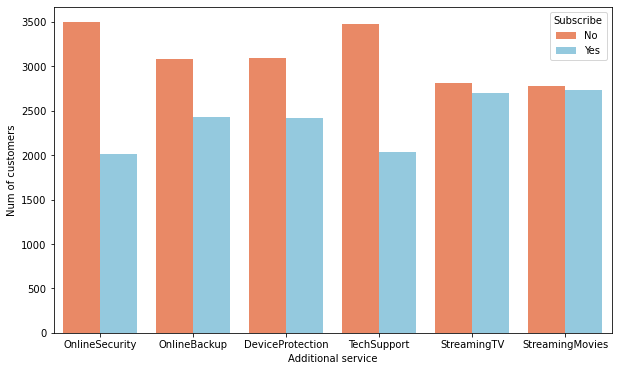

In [23]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=service_df, x='Service', hue='Subscribe', palette=['coral', 'skyblue'])
ax.set(xlabel='Additional service', ylabel='Num of customers')
plt.show()

Eventhough, the majority of customers did not subscribe extra services. Streaming Movies and Streaming Tv seems like to be more popular services among others.

#### 5. Popular payment method among different contract

In [24]:
contract = df.groupby(['Contract','PaymentMethod']).agg(
    num_user =  ('PaymentMethod', 'count')).reset_index()

contract

,Contract,PaymentMethod,num_user
0,Month-to-month,Bank transfer (automatic),589
1,Month-to-month,Credit card (automatic),543
2,Month-to-month,Electronic check,1850
3,Month-to-month,Mailed check,893
4,One year,Bank transfer (automatic),391
5,One year,Credit card (automatic),398
6,One year,Electronic check,347
7,One year,Mailed check,336
8,Two year,Bank transfer (automatic),562
9,Two year,Credit card (automatic),580


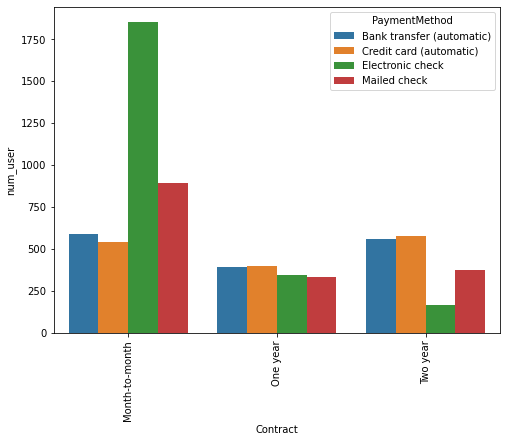

In [25]:
plt.figure(figsize=(8,6))
sns.barplot(data=contract, x='Contract', y='num_user', hue='PaymentMethod')
plt.xticks(rotation=90)
plt.show()

Electronic is popular among people with month-to-month contract. But for customers in Two Year contract, they prefer Automatic payment method (Bank transfer and credit card).

## Feature Encoding

Most algorithms cannot handle categorical variables without being translated into a numerical value, therefore we need to encode our variable to result in better models. There are 3 types of categorical value, which are binary ordinal and nominal. To address which one is which and decide which type of encoding should we do to them, let's check our column unique value.

In [26]:
#Check number of unique value in each columns
df[categoricals].nunique()

gender              2
Partner             2
Dependents          2
PhoneService        2
MultipleLines       3
InternetService     3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
StreamingTV         3
StreamingMovies     3
Contract            3
PaperlessBilling    2
PaymentMethod       4
Churn               2
dtype: int64

Here, we can see that 
* `gender`, `Partner`,`Dependants`, `PaperlessBilling`, `PhoneService`, and `Churn` has 2 distinct value, we need to encode to 0 and 1.
* For column `MultipleLines` there are 3 values. However, since we already have a `PhoneService` column, we can assume 'No phone service' is the same as 'No'. After that we can do Label Encoding.
* For the `InternetService` column, I will first categorize Fiber Optic and DSL as `Has_InternetService`. After that we just create a column containing what service is used and drop `InternetService`.
* Other than that, we will do one Hot Encoding for `Contract` and `PaymentMethod`.

Because we want to do some change, we should copy our original data and change only in the data copy.

In [27]:
dff = df.copy()
dff.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [28]:
# encode columns with 2 distinct value
columns_binary = ['gender',
                  'Partner',
                  'PhoneService',
                  'Dependents',
                  'PaperlessBilling',
                  'Churn']
le = preprocessing.LabelEncoder()
dff[columns_binary] = dff[columns_binary].apply(le.fit_transform)
dff.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [29]:
# encode MultipleLines column
dff['MultipleLines'].replace('No phone service','No', inplace=True)
le.fit(dff['MultipleLines'])
dff['MultipleLines'] = le.transform(dff['MultipleLines']) 
dff.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,0,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,0,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,0,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [30]:
# encode internet service related columns
internet_column = ['OnlineSecurity',
                   'OnlineBackup',
                   'DeviceProtection',
                   'TechSupport',
                   'StreamingTV',
                   'StreamingMovies']

for column in internet_column:
    dff[column].replace('No internet service','No', inplace=True)
    
dff[internet_column] = dff[internet_column].apply(le.fit_transform)
dff.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [31]:
#encode columns with more than 2 distinct values
onehot_cols = ['InternetService', 'Contract', 'PaymentMethod']
for col in onehot_cols:
    dummies = pd.get_dummies(dff[col],prefix=col)
    dff = pd.concat([dff, dummies], axis=1) 
dff.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,DSL,0,1,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,DSL,1,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,0,DSL,1,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,DSL,1,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,Fiber optic,0,0,...,0,1,0,1,0,0,0,0,1,0


In [32]:
#drop previous columns
dff = dff.drop(onehot_cols, axis = 1)
dff.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


Now we have our data ready for some modeling. We can first split our data, check the multicollinearity and train our data into machine learning model.

# Split the data

Data splitting is frequently used in machine learning to prevent overfitting. In that situation, a machine learning model fits its training data too well but unable to consistently fit new data. Now we split our train and test data to the ratio 80:20. We also should divide our data into features (X) and target variable (y).

In [33]:
X = dff.drop('Churn', axis=1)
y = dff['Churn']

X_train, X_test, y_train,y_test = train_test_split(X, y,
                                                  test_size = 0.2,
                                                  random_state = 42)

# Multicollinearity

Multicollinearity among independent variables will result in less reliable statistical inferences. Therefore, we should check them using heatmap.

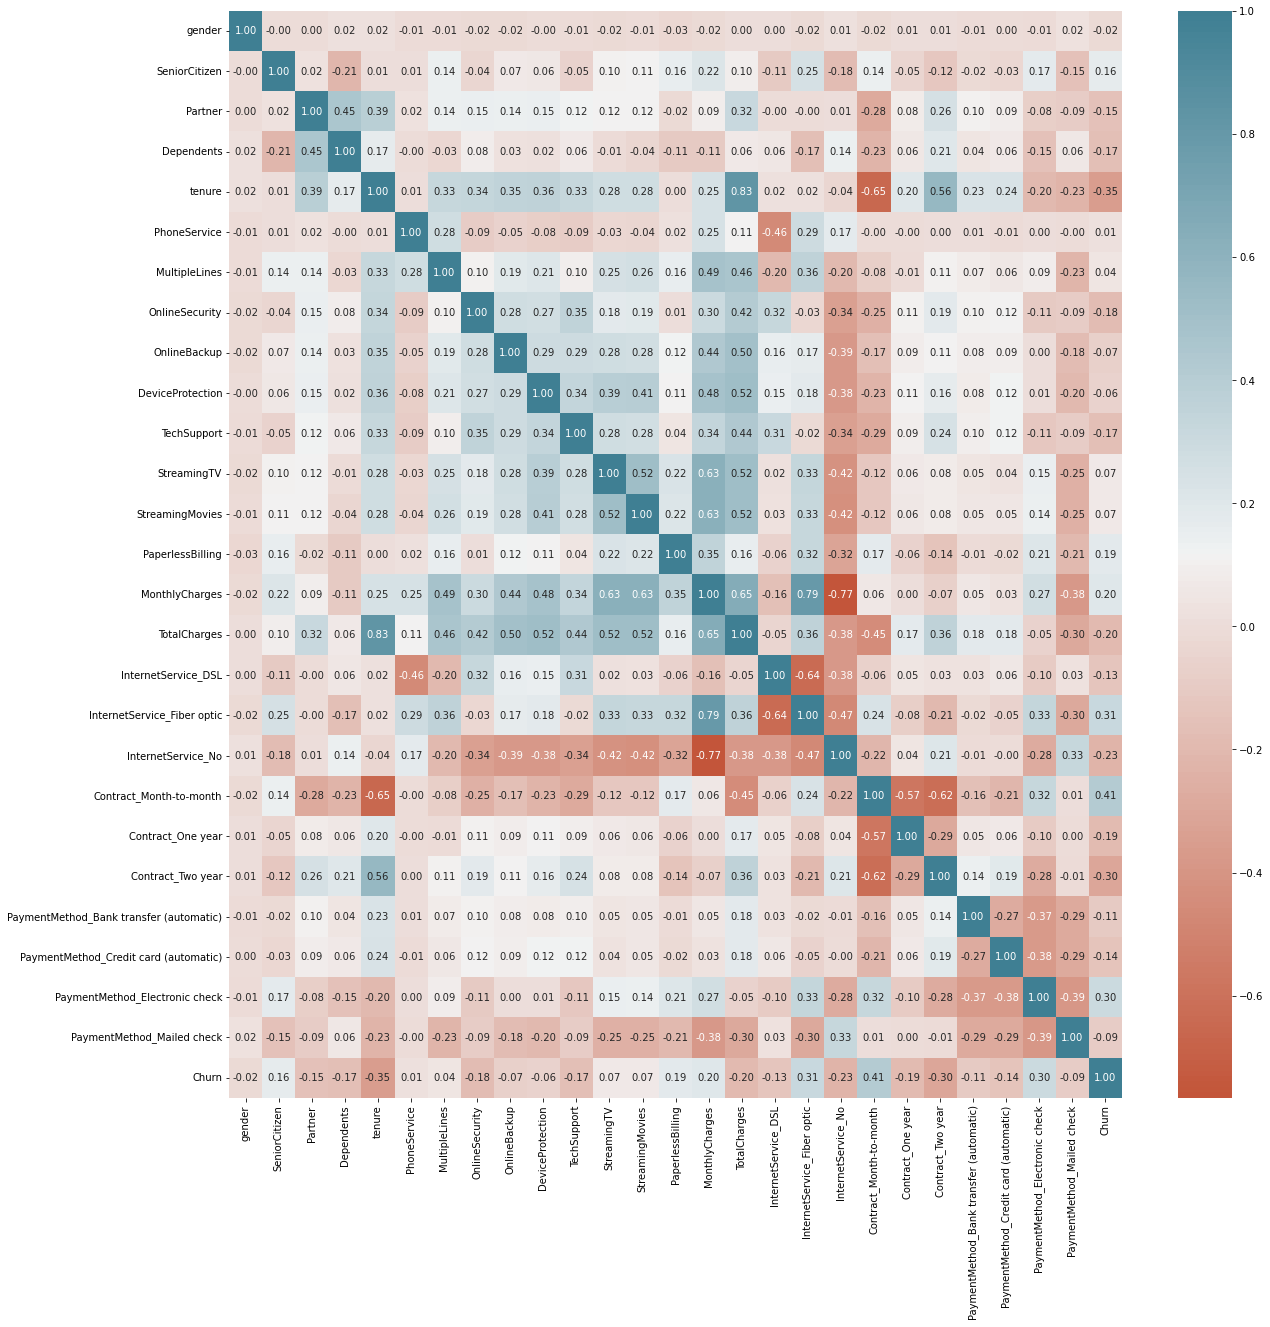

In [34]:
train = pd.concat([X_train, y_train], axis=1)
correlation = train.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap=sns.diverging_palette(20, 220, n=200))
plt.show()

There is multicollinearity between `Tenure` and `TotalCharges`. Because `Tenure` shows higher correlation to `Churn`, we can drop `TotalCharges`.

In [35]:
#Drop redundant features in both train and test
X_train = X_train.drop('TotalCharges', axis=1)
X_test = X_test.drop('TotalCharges', axis=1)

## Choose the appropriate metric for fitting the model

In [36]:
#Check imbalance of target feature
target = y_train.value_counts().reset_index()
target.rename(columns={'index':'Churn','Churn':'freq'}, inplace=True)
target['percentage'] = round((target['freq']/target['freq'].sum())*100,2)
target

,Churn,freq,percentage
0,0,4130,73.42
1,1,1495,26.58


* Due to imbalance distribution on feature targets, we cannot use accuracy as evaluation metrics.
* We use recall (sensitivity) because we want to know which customer who most likely to churn! We want to succesfully find more customers that end up churning so we can do business strategy to prevent the churn to happen!
* It is okay to predict customers will churn even though they actually won't, rather than let the customers churn because we can't find them.

## Modeling

In this step, I immediately use `GridsearchCV` to do hyperparameter tuning.

### Random Forest

In [37]:
#define the estimator/model
rf = RandomForestClassifier(random_state=42)

In [38]:
%%time

parameters = {
    'n_estimators': (10, 50, 100),
    'max_depth':(5, 10, 20),
}

# note: we use recall
rf_gridcv = GridSearchCV(rf, parameters, cv=5, scoring='recall')
rf_gridcv.fit(X_train, y_train)

CPU times: user 11.3 s, sys: 370 ms, total: 11.7 s
Wall time: 12.5 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': (5, 10, 20),
                         'n_estimators': (10, 50, 100)},
             scoring='recall')

#### Evaluation Metrics on Test Data

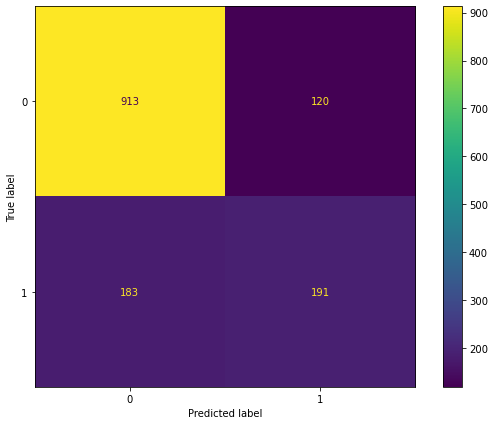

In [39]:
# the confusion matrix

fig, ax = plt.subplots(figsize=(10,7))
y_pred = rf_gridcv.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=rf_gridcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf_gridcv.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

Based on confusion matrix:
* We successfully predicted 913 customers who don't churn and 191 who churn
* There are 120 customers who are predicted to churn when they actually won't
* There are 183 customers who are predicted to not churn when they actually churn

In [40]:
y_pred = rf_gridcv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1033
           1       0.61      0.51      0.56       374

    accuracy                           0.78      1407
   macro avg       0.72      0.70      0.71      1407
weighted avg       0.77      0.78      0.78      1407



* Based on recall metric, our model performance on the test data is 0.51, which means out of all the people who actually churn, our model has detected 51% of them.


* The precision value on the test data is 0.61, which means that from all data we predicted churn, we managed to guess 61% correctly. There are 39% of people who we think will churn when they really won't.


* I think recall value of 0.51 is not enough even it's not a life-or-death situation. So, let's try to improve our prediction by doing Random forest with oversampling (SMOTE) and try XGBoost model.

### Random Forest with SMOTE

Oversampling the minority class is one way to deal with imbalance datasets. Duplicating examples from the minority class is the simplest method, but these examples don't provide any new insight into the model. Instead, fresh examples can be created by synthesizing the old ones. Here we will use Synthetic Minority Oversampling Technique, or SMOTE as a method to oversampling for the minority class.

In [41]:
#Imbalance handling in train data

sm = over_sampling.SMOTE(random_state=42)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print(f'''Shape of X before SMOTE: {X_train.shape}
Shape of X after SMOTE: {X_train_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_train_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (5625, 25)
Shape of X after SMOTE: (8260, 25)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: Churn, dtype: float64

In [42]:
#define the estimator/model
rf_sm = RandomForestClassifier(random_state=42)

In [43]:
%%time

parameters = {
    'n_estimators': (10, 50, 100),
    'max_depth':(5, 10, 20)
}

# note: we use recall
rf_gridcv_sm = GridSearchCV(rf_sm, parameters, cv=5, scoring='recall')
rf_gridcv_sm.fit(X_train_sm, y_train_sm)

CPU times: user 14.3 s, sys: 384 ms, total: 14.7 s
Wall time: 14.6 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': (5, 10, 20),
                         'n_estimators': (10, 50, 100)},
             scoring='recall')

In [44]:
cv_result = pd.DataFrame(rf_gridcv_sm.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
4,"{'max_depth': 10, 'n_estimators': 50}",0.862954,1
5,"{'max_depth': 10, 'n_estimators': 100}",0.860291,2
3,"{'max_depth': 10, 'n_estimators': 10}",0.857143,3
1,"{'max_depth': 5, 'n_estimators': 50}",0.850605,4
2,"{'max_depth': 5, 'n_estimators': 100}",0.846973,5
8,"{'max_depth': 20, 'n_estimators': 100}",0.843584,6
7,"{'max_depth': 20, 'n_estimators': 50}",0.842857,7
0,"{'max_depth': 5, 'n_estimators': 10}",0.835835,8
6,"{'max_depth': 20, 'n_estimators': 10}",0.817676,9


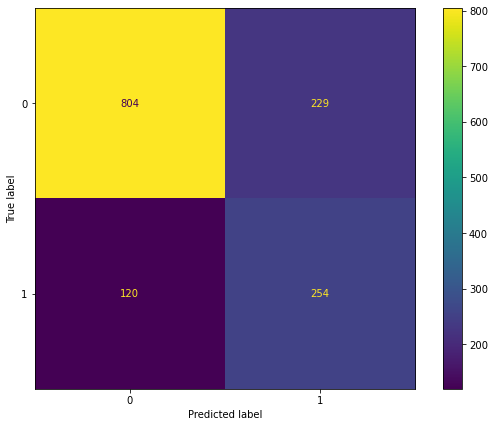

In [45]:
# the confusion matrix

fig, ax = plt.subplots(figsize=(10,7))
y_pred_sm = rf_gridcv_sm.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred_sm, labels=rf_gridcv_sm.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf_gridcv_sm.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

Based on confusion matrix:

* We successfully predicted 804 customers who don't churn and 254 who churn
* There are 229 customers who are predicted to churn when they actually won't
* There are 120 customers who are predicted to not churn when they actually churn

In [46]:
y_pred = rf_gridcv_sm.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1033
           1       0.53      0.68      0.59       374

    accuracy                           0.75      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.75      0.76      1407



* Our prediction show much improvement after oversampling (SMOTE)

* Based on recall metric, our model performance on the test data is 0.68, which means out of all the people who actually churn, our model has detected 68% of them. With proper strategy, we can prevent 68% of people who churn!

* The precision value on the test data is 0.53, which means that from all data we predicted churn, we managed to guess 53% correctly. However, we don't really care about our precision metric.

### XGBoost

* For the sake of curiosity, I will try XGBoost because it is said that if we tune 'scale_post_weight' parameter, it can handle data imbalance.
* In addition I will tune 'min_child_weight' and 'max_depth' to control overfitting.

In [47]:
xgboost = xgb.XGBClassifier()

In [48]:
%%time

parameters = {
        'min_child_weight': [1, 5, 10],
        'scale_pos_weight': [1, 3, 5, 10],
        'max_depth': [3, 5, 10],
        }

# note: we use recall
xgb_gridcv = GridSearchCV(xgboost, parameters, cv=5, scoring='recall')
xgb_gridcv.fit(X_train, y_train) 

CPU times: user 6min 29s, sys: 10.8 s, total: 6min 40s
Wall time: 2min 8s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...hot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'max_depth': [3, 5, 10],
                         'min_child_weight': [1, 5, 10],
                         'scale_pos_weight': [1, 3, 5, 10]},
             scoring='recall')

In [49]:
cv_result = pd.DataFrame(xgb_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
11,"{'max_depth': 3, 'min_child_weight': 10, 'scal...",0.909030,1
3,"{'max_depth': 3, 'min_child_weight': 1, 'scale...",0.901672,2
7,"{'max_depth': 3, 'min_child_weight': 5, 'scale...",0.901003,3
6,"{'max_depth': 3, 'min_child_weight': 5, 'scale...",0.852843,4
10,"{'max_depth': 3, 'min_child_weight': 10, 'scal...",0.850167,5
23,"{'max_depth': 5, 'min_child_weight': 10, 'scal...",0.847492,6
2,"{'max_depth': 3, 'min_child_weight': 1, 'scale...",0.842140,7
19,"{'max_depth': 5, 'min_child_weight': 5, 'scale...",0.831438,8
15,"{'max_depth': 5, 'min_child_weight': 1, 'scale...",0.803344,9
22,"{'max_depth': 5, 'min_child_weight': 10, 'scal...",0.789967,10


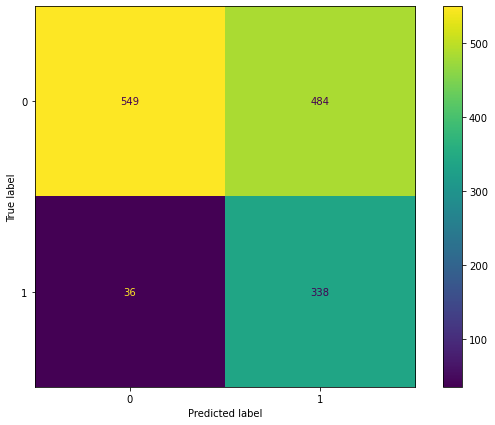

In [50]:
# the confusion matrix

fig, ax = plt.subplots(figsize=(10,7))
y_pred = xgb_gridcv.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=xgb_gridcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=xgb_gridcv.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

Based on confusion matrix:
* We successfully predicted 549 customers who don't churn and 338 who churn
* There are 484 customers who are predicted to churn when they actually won't
* There are 36 customers who are predicted to not churn when they actually churn

In [51]:
y_pred = xgb_gridcv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.53      0.68      1033
           1       0.41      0.90      0.57       374

    accuracy                           0.63      1407
   macro avg       0.67      0.72      0.62      1407
weighted avg       0.80      0.63      0.65      1407



* Our prediction shows much more improvement!

* Now, our model performance on the test data is 0.90, which means out of all the people who actually churn, our model has detected 93% of them. With proper strategy, we can prevent 90% of people who churn! 

* The precision value on the test data is 0.41, which means that from all data we predicted churn, we managed to guess 41% correctly.

* We can see when our recall value get higher, the precision is lower. It makes sense because recall and precision have trade-off relationship. However, we don't really care about precision and glad with higher value of recall.

## Conclusion

After doing the modeling, we can see that XGBoost is the most appropriate model for imbalanced data. But it should be noted, we have not done feature selection here at all. Feature selection is the process of selecting features that affect the dataset. With feature selection, the result could be improved.